The code in this notebook analyses data produced and partly preprocessed by 'g2-corellations-histogram.py'. The next cell contains a snippet of the relavent part of that code. I include it here as shows some more of my experience in handling large sets of numerical data efficiently. It will not run. The jupiter notebook section can be run. 

In [ ]:
def CrossCorrelation(self):
        # Set times used for coincidence window (in pico seconds)
        #coincidence_start = 6.4e3; coincidence_end = 7.5e3
        
        self.width = 1.5e3
        
        peak_02 = 5.9e3
        coincidence_start = peak_02-self.width/2; coincidence_end = peak_02+self.width/2 #1100uW of P780 
        self.lower_02 = coincidence_start; self.higher_02 = coincidence_end
        
        peak_01 = 36.8e3
        self.lower_01 = peak_01-self.width/2; self.higher_01 = peak_01+self.width/2 #1100uW of P780 
        
        
        herald_channel = 0; signal_channel = 1
        herald_channel2 = 0; signal_channel2 = 2

        # Store which channel clicks (0, 1 or 2) and the timetag for each click during a [~1 second] period
        channels,times = self.timetags[:,0],self.timetags[:,1] 
        
        # print "First timetag", times[0] ###
        binsize = 26.9851 
        nbins = int(self.dtmax/binsize + 1e-10) # Expect 1482 bins for dtmax = 40000 ps and binsize 26.9851 picoseconds
        dtmaxact = binsize*nbins
        # histogram resets in cumulative mode
        if self.cumulativeflag == False:
            self.correlation_hist = np.zeros(nbins)
            self.correlation_hist2 = np.zeros(nbins)
            self.correlation_hist21 = np.zeros(nbins) 
            self.correlation_hist20 = np.zeros(nbins)

            self.heralded_correlation_hist = np.zeros(nbins)

            self.temp_output = [] # To hold count rates at each timestep
            self.t0 = time.time() # time when run is started
            self.t1 = 0 # time when save happens
            self.counter = 0 # used to keep track of saves
            self.bigcounter = 0 # used to keep track of times around the loop
            self.dt_02s = []
            self.dt_21s = []
        print '----------------------------------------------------------------'
        
                
        for i in range(1,self.dntags+1):
            
            
            # Record the index at which there is a click on herald and the "subsequent" click is on signal
            # "Subsequent" is either "the next click" (i.e. i = 1) or "the click after the next" (i.e. i = 2) and so on...
            indices = np.arange(0,len(channels)-i,1,dtype=int)[(channels[:-i] == herald_channel) & (channels[i:] == signal_channel)] # i.e. indices01
            indices2 = np.arange(0,len(channels)-i,1,dtype=int)[(channels[:-i] == herald_channel2) & (channels[i:] == signal_channel2)] # i.e. indices02
            indices21 = np.arange(0,len(channels)-i,1,dtype=int)[(channels[:-i] == 2) & (channels[i:] == 1)]
            indices20 = np.arange(0,len(channels)-i,1,dtype=int)[(channels[:-i] == 2) & (channels[i:] == 0)]
            
            # timegaps are the time between "subsequent" clicks
            timegaps = times[indices+i]-times[indices]
            #timegaps = timegaps + 5000 #Add a delay to this channel
            
            timegaps2 = times[indices2+i]-times[indices2]
            #timegaps2 = timegaps2 + 10000 #Add a delay to this channel
            
            timegaps21 = times[indices21+i]-times[indices21]
            timegaps20 = times[indices20+i]-times[indices20]                                                 
            print str(i)+':', len(timegaps[timegaps<dtmaxact])
            
            # histogram data: x are the bin edges
            hist_i, x = np.histogram(timegaps,bins=nbins,range=(0,dtmaxact))
            hist_i2, x2 = np.histogram(timegaps2,bins=nbins,range=(0,dtmaxact))
            hist_i21, x21 = np.histogram(timegaps21,bins=nbins,range=(0,dtmaxact))
            self.correlation_hist += hist_i
            self.correlation_hist2 += hist_i2   
            self.correlation_hist21 += hist_i21
            hist_i20, x20 = np.histogram(timegaps20,bins=nbins,range=(0,dtmaxact))
            self.correlation_hist20 += hist_i20                                                                       
			
            ## look for 3-channel corellations: a click on CH0 followed by CH2 followed by CH1
            for j in range(1,4):
                indices_all = np.arange(0,len(channels)-i-j,dtype=int)[(channels[0:-i-j] == 0) & (channels[i:-j] == 2) & (channels[i+j:] == 1)]
                dt_02 = times[indices_all+i]-times[indices_all]
                indices = indices_all[(dt_02>coincidence_start)&(dt_02<coincidence_end)]
                dt_02 = times[indices+i]-times[indices]
                self.dt_02s.extend(dt_02)
                dt_21 = times[indices+i+j]-times[indices+i]
                self.dt_21s.extend(dt_21)
                
                hist_ij, x = np.histogram(dt_21,bins=nbins,range=(0,dtmaxact))
                

                self.heralded_correlation_hist += hist_ij

                #print "i",i,"j",j, sum(self.heralded_correlation_hist)
                #print self.dt_02s
        # Ensures that leftmost bin starts at t = 0    
        self.correlation_x = x[:-1]+(binsize/2) 
        self.correlation_x2 = x2[:-1]+(binsize/2) 
        self.correlation_x21 = x21[:-1]+(binsize/2)  
        self.correlation_x20 = x20[:-1]+(binsize/2) # Ensures that leftmost bin starts at t = 0                                                                                        
        self.correlation_x021 = x[:-1]+(binsize/2) 

        
        # info contains integration time, ch0 count rate, ch1 count rate, ch2 count rate, ch3 count rate
        # averages in cumulative mode
        if self.cumulativeflag == False:
            #### Be careful not to have such a low count rate that this no longer gives an accurate integration time
            self.inttime = times[-1]/1e12
            self.ncounts_ch0 = len(channels[channels==0])
            self.ncounts_ch1 = len(channels[channels==1])
            self.ncounts_ch2 = len(channels[channels==2])
            self.ncounts_ch3 = len(channels[channels==3])
            #try:
            #    np.savetxt('delete.csv',np.array([channels,times]).transpose(),delimiter=',')
            #except:
            #    print "couldn't save"

        else:
            #### Be careful not to have such a low count rate that this no longer gives an accurate integration time
            self.inttime += times[-1]/1e12
            self.ncounts_ch0 += len(channels[channels==0])
            self.ncounts_ch1 += len(channels[channels==1])
            self.ncounts_ch2 += len(channels[channels==2])
            self.ncounts_ch2 += len(channels[channels==3])
        # print 'Number of bins', nbins #1482 bins expected for 40 ns window
        print '------------------------------------------'
        print '--  Integration time =', times[-1]/1e12, 's '
        print '--  Ch0 count rate =', len(channels[channels==0])*1e9/times[-1], 'kHz  '
        print '--  Ch1 count rate =', len(channels[channels==1])*1e9/times[-1], 'kHz  '
        print '--  Ch2 count rate =', len(channels[channels==2])*1e9/times[-1], 'kHz  '
        print '--  Ch3 count rate =', len(channels[channels==3])*1e9/times[-1], 'kHz  '
        print '------------------------------------------'

        # Record the count rate at each timestep
        self.corr_info = [self.inttime,len(channels[channels==0])*1e9/times[-1],len(channels[channels==1])*1e9/times[-1],len(channels[channels==2])*1e9/times[-1],len(channels[channels==3])*1e9/times[-1]]
        self.t1 = time.time()
        self.t_elapsed = self.t1 - self.t0
        self.temp_output.append([self.t_elapsed, self.corr_info[0], self.corr_info[1], self.corr_info[2], self.corr_info[3], self.corr_info[4]])
   
        # info contains integration time, ch0 count rate, ch1 count rate, ch2 count rate, ch3 count rate (and later g2max and pair rate)
        self.correlation_info = [self.inttime,self.ncounts_ch0*1e-3/self.inttime,self.ncounts_ch1*1e-3/self.inttime,self.ncounts_ch2*1e-3/self.inttime,self.ncounts_ch3*1e-3/self.inttime]
        
        ########## Calculate and print statistics ###########
        normfactor = binsize*1e-12*self.correlation_info[0]*self.correlation_info[1]*1e3*self.correlation_info[2]*1e3
        normfactor2 = binsize*1e-12*self.correlation_info[0]*self.correlation_info[1]*1e3*self.correlation_info[3]*1e3
        normfactor20 = binsize*1e-12*self.correlation_info[0]*self.correlation_info[3]*1e3*self.correlation_info[1]*1e3
        normfactor21 = binsize*1e-12*self.correlation_info[0]*self.correlation_info[2]*1e3*self.correlation_info[3]*1e3
        
        nbins = len(self.correlation_hist)
        nbins2 = len(self.correlation_hist2)
        ncor_uncorrected = sum(self.correlation_hist) # Coincidence rate (RSM)
        ncor_uncorrected2 = sum(self.correlation_hist2) # Coincidence rate (RSM)
        ncor = sum(self.correlation_hist)-normfactor*nbins # Pair rate between herald and signal1
        ncor2 = sum(self.correlation_hist2)-normfactor2*nbins # Pair rate between herald and signal2
        
        print 'Calculating correlation between Ch0 (herald) and Ch1 (signal)'
        print 'Total Integration time             =', self.correlation_info[0], 's'
        print 'Ch0 average count rate             =', self.correlation_info[1], 'kHz'
        print 'Ch1 average count rate             =', self.correlation_info[2], 'kHz'
        print 'Ch2 average count rate             =', self.correlation_info[3], 'kHz'
        print 'Ch3 average count rate             =', self.correlation_info[4], 'kHz'
        print 'Pair count rate (uncorrected)      =', ncor_uncorrected/self.correlation_info[0], 'Hz'
        print 'Pair count rate (corrected  )      =', ncor/self.correlation_info[0], 'Hz'
        print 'Pair count rate 2 (corrected  )      =', ncor2/self.correlation_info[0], 'Hz'
        print 'Heralding efficiency (uncorrected) =', ncor_uncorrected/(self.correlation_info[0]*self.correlation_info[1]*1e3)
        print 'Heralding efficiency (corrected  ) =', ncor/(self.correlation_info[0]*self.correlation_info[1]*1e3)
        print ''
        

            
            
        ########### Plot cross correlation vs. time delay #############
        self.ax.clear()
        
        self.ax.tick_params(axis='both', which='both', bottom=True)
        self.ax.set_xlabel('Delay (ns)')
        self.ax.set_ylabel('Normalised Cross Correlation')

        x,y = bindata(self.correlation_x,self.correlation_hist,self.plotbinfactor)
        x2,y2 = bindata(self.correlation_x2,self.correlation_hist2,self.plotbinfactor)
        x21,y21 = bindata(self.correlation_x21,self.correlation_hist21,self.plotbinfactor)
        x021,y021 = bindata(self.correlation_x021,self.heralded_correlation_hist,self.plotbinfactor)#
        x20,y20 = bindata(self.correlation_x20,self.correlation_hist20,self.plotbinfactor)
        self.ax.plot(x/1e3,y/(normfactor*2**self.plotbinfactor), color = 'red')   #Ch0 then Ch1 
        self.ax.plot(x2/1e3,y2/(normfactor2*2**self.plotbinfactor), color = 'blue') #Ch0 then Ch2
        self.ax.plot(x21/1e3,y21/(normfactor21*2**self.plotbinfactor), color = 'green') #Ch2 then Ch1
        #self.ax.plot(x20/1e3,y20/(normfactor20*2**self.plotbinfactor), color = 'purple')   #Ch2 then Ch0
        self.ax.plot(x021/1e3,y021/(normfactor21*2**self.plotbinfactor), color = 'orange')#Ch0 then Ch2 then Ch1
        self.canvas.draw() 
   
        print "We expect red g2max at:", peak_01/1e3
        print "At this time we get red g2max:", (x[np.argmax(y)]/1e3)
        print "Red g2max = ", (y/(normfactor*2**self.plotbinfactor)).max()
        
        print "We expect blue g2max at:", peak_02/1e3
        print "At this time we get blue g2max:", (x2[np.argmax(y2)]/1e3)
        print "Blue g2max = ", (y2/(normfactor2*2**self.plotbinfactor)).max()
        
        
        self.correlation_info.append((y/(normfactor*2**self.plotbinfactor)).max()) # Add g2_max to self.correlation_info which will be saved in data-info.txt
        self.correlation_info.append(ncor/self.correlation_info[0]) # Add pair-rate to self.correlation_info which will be saved as data-info
        
        #### Autosave if the instantaneous count rate drops below a certain value ####
        inst_Ch0_countrate = len(channels[channels==0])*1e9/times[-1]
        if (self.autosaveflag == True) and (inst_Ch0_countrate < self.autosaverate):
            print "Warning: Ch1 count rate dropped below", self.autosaverate, " kHz,", inst_Ch0_countrate, "Hz"  
            import datetime; currentDT = datetime.datetime.now()            
            self.AutoSave()
            print "Autosaved"
            print "Autostopped at", currentDT
        
        #### Autosave at regular intervals ###
        self.bigcounter += 1       
        if self.bigcounter % (200*3) == 0: #Every 200 times around the loop is ~4 mins
            if self.counter == 0: 
                self.counter += 1
            else:
                
                directoryname = "shot"+str(self.counter)
                print "Going to autosave after seconds:", int(time.time()-self.t0)
                
                filepath = os.getcwd()+"\\"+directoryname
                print "Now we will autosave to:", filepath

                if os.path.isdir(filepath) == False: os.mkdir(filepath)
                np.save(filepath+"\\dataCh0thenCh1",np.array([self.correlation_x,self.correlation_hist]).transpose())
                np.save(filepath+"\\dataCh0thenCh2",np.array([self.correlation_x2,self.correlation_hist2]).transpose())
                np.save(filepath+"\\dataCh2thenCh1",np.array([self.correlation_x21,self.correlation_hist21]).transpose())
                np.save(filepath+"\\dataCh0thenCh2thenCh1",np.array([self.correlation_x021, self.heralded_correlation_hist]).transpose())
                np.save(filepath+"\\dataCh2thenCh0",np.array([self.correlation_x20,self.correlation_hist20]).transpose())
                header = 'Integration time (s), Ch0 count rate (kHz), Ch1 count rate (kHz), Ch2 count rate (kHz), Ch3 count rate (kHz), g2_max_red_curve, pair-rate (Hz'
                header2 = 'Time from start (s), Integration time (s), Ch0 count rate (kHz), Ch1 count rate (kHz), Ch2 count rate (kHz), Ch3 count rate (kHz)'
                np.savetxt(filepath+'\\data-timed.txt',self.temp_output,header=header2,delimiter=',')
                np.savetxt(filepath+'\\data-info.txt',self.correlation_info,header=header,delimiter=',')
                self.fig.savefig(filepath+'\\screenshot.png')# Save g(2) image on screen
                channels,times = self.timetags[:,0],self.timetags[:,1] 
                np.save(filepath+"\\datachannels", channels)
                np.save(filepath+"\\datatimetags", times)
                np.savetxt(filepath+"\\dt_02s.csv", np.array(self.dt_02s))
                np.savetxt(filepath+"\\dt_21s.csv", np.array(self.dt_21s))
                
                dataCh0thenCh2thenCh1 = np.array([self.correlation_x021, self.heralded_correlation_hist]).transpose()
                dataCh0thenCh1 = np.array([self.correlation_x,self.correlation_hist]).transpose()
                dataCh0thenCh2 = np.array([self.correlation_x2,self.correlation_hist2]).transpose()
                
                windowed_021_data = dataCh0thenCh2thenCh1[((dataCh0thenCh2thenCh1[:,0]>(self.lower_01-self.lower_02-self.width/2)) & (dataCh0thenCh2thenCh1[:,0]<(self.lower_01-self.lower_02+self.width/2))),:]
                counts_021 = np.sum(windowed_021_data[:,1])
                print('no. of 021 counts = ',counts_021)
                
                # 02 counts
                windowed_02_data = dataCh0thenCh2[((dataCh0thenCh2[:,0]>self.lower_02) & (dataCh0thenCh2[:,0]<self.higher_02)),:]
                counts_02 = np.sum(windowed_02_data[:,1])
                print('no. of 02 counts = ',counts_02)

                # 01 counts
                windowed_01_data = dataCh0thenCh1[((dataCh0thenCh1[:,0]>self.lower_01) & (dataCh0thenCh1[:,0]<self.higher_01)),:]
                counts_01 = np.sum(windowed_01_data[:,1])
                print('no. of 01 counts = ',counts_01)
                
                info = np.array(self.temp_output)
                Ch0_rate = np.average(info[:,2])*1000 
                print('Ch0 rate =',Ch0_rate)
                Ch0_int_time = info[-1,1]
                print('integration time = ',Ch0_int_time)
                Ch0_counts = Ch0_rate * Ch0_int_time
                
                g2 = counts_021 * Ch0_counts/(counts_01 * counts_02)
                print('g2 = ',g2)
                g2_error = np.sqrt(counts_021)/counts_021 * g2
                print('g2 error = ', g2_error)
                
                self.calculated_g2 = np.array([g2,g2_error, counts_021, counts_02, counts_01, Ch0_counts])  
                header3 = 'g2, g2_error, counts_021, counts_02, counts_01, Ch0_counts'                
                np.savetxt(filepath+'\\g2(0).txt',self.calculated_g2,header=header3,delimiter=',')
                
                #raw_input("Press Enter to continue...")
                self.counter += 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.optimize
import matplotlib.gridspec as gridspec


def gaussian(x, amplitude, centre, width, offset):
    """ Gaussian function with amplitude 'a', center 'c', width 'w'. 
    FWHM of this fn is 2 *sqrt(2 *ln(2))*w  """
    G = amplitude * np.exp(-(x-centre)**2 / (2*width**2)) + offset
    return G


# https://plot.ly/python/smoothing/
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        average = np.average(data[i:i + len(triangle)], weights = triangle)
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    #smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    #while len(smoothed) < len(data):
    #    smoothed.append(smoothed[-1])
    return smoothed

def smoothRectangle(data, degree):
    rectangle=[1]*degree*2 
    smoothed=[]
    for i in range(0, len(data) - degree * 2): ##start at first element
        point=data[i:i + len(rectangle)] * rectangle
        smoothed.append(np.sum(point)/np.sum(rectangle))
    # Handle boundaries -- not good
    #smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    #while len(smoothed) < len(data):
    #    smoothed.append(smoothed[-1])
    return smoothed


def bindata(x,y,binfactor=0):
    for i in range(binfactor):
        y = (y[:-1:2]+y[1::2])
        x = (x[:-1:2]+x[1::2])/2
    return x,y

In [2]:
cs = ['#AA2B4A','#006388','#7E317B','#E8E391','#9FA161','#C4E5FA']

plt.rc('figure',figsize=[6.8,4.2])
plt.rc('font',**{'family':'Serif','serif':['Times New Roman']})
params={'axes.labelsize':13,'xtick.labelsize':13,'ytick.labelsize':13,'legend.fontsize': 13,'mathtext.fontset':'cm','mathtext.rm':'serif'}
plt.rcParams.update(params)

# Smoothing and binning on the same graph

time_unit =  26.99 ps
blue max =  5.47
red max =  4.27
blue max time =  14.38 ns
red max time =  36.54 ns


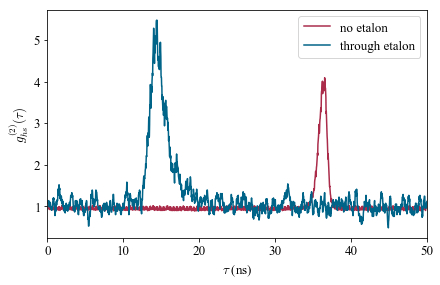

In [3]:
## load .npy files
## files are two column arrays of histogrammed data, first column is timegaps, second is counts with that time gap

directoryname = "X:\\thermal-vapours//rawdata-CQO//2022-02-21-withet//2.542//final"

dataCh0thenCh2 = np.load(directoryname+"//"+"dataCh0thenCh2.npy")
dataCh0thenCh1 = np.load(directoryname+"//"+"dataCh0thenCh1.npy")

x02= dataCh0thenCh2[:,0]; x01= dataCh0thenCh1[:,0]

#print(len(x02))

smoothingdegree = 5
y02 = np.array(smoothRectangle(dataCh0thenCh2[:,1], degree=smoothingdegree))
y01 = np.array(smoothRectangle(dataCh0thenCh1[:,1], degree=smoothingdegree))

## adjust x-axis to match smoothed function shape, with 'time_unit' between points, and first point at 'smoothingdegree * time_unit'
time_unit = x02[1]-x02[0]; x02 = (np.arange(0,len(y02),1)+smoothingdegree)*time_unit 
time_unit = x01[1]-x01[0]; x01 = (np.arange(0,len(y02),1)+smoothingdegree)*time_unit

#print(len(y02),len(x02))

print('time_unit = ','{0:.2f}'.format(time_unit),'ps')

## /1000 to convert from ps to ns
## normalise by dividing by mean of 1st 1000 points because background level is 1
x_blue = x02/1000; y_blue = y02/np.average(y02[-1000:])
x_red = x01/1000; y_red = y01/np.average(y01[-1000:])

## find maximum values of both traces

red_max = y_red.max() 
blue_max = y_blue.max()

print('blue max = ','{0:.2f}'.format(blue_max))
print('red max = ', '{0:.2f}'.format(red_max))

# find time at which maximum occurs
red_max_time = x_red[np.argmax(y_red)] 
blue_max_time = x_blue[np.argmax(y_blue)]
print('blue max time = ','{0:.2f}'.format(blue_max_time), 'ns')
print('red max time = ', '{0:.2f}'.format(red_max_time), 'ns')

## save max values to txt file
#np.savetxt(directoryname+"//"+'ghsmax.txt', np.array([blue_max,red_max]))
#np.savetxt(directoryname+"//"+'ghsmaxtime.txt', np.array([blue_max_time, red_max_time]))



## plot data
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_xlabel("$\\tau$ (ns)")
ax1.set_ylabel("$g^{(2)}_{hs}(\\tau)$")

ax1.plot(x01/1000, y_red/np.average(y_red), color = cs[0], label = 'no etalon')
ax1.plot(x02/1000, y_blue/np.average(y_blue[-1000:]), color = cs[1], label = 'through etalon')
ax1.set_xlim(0,50)
ax1.legend()

#plt.savefig(directoryname+"//"+'ghs-50.pdf')
plt.show()


blue opt values =  [ 3.73693572 14.55998622  1.07089207  1.02382394]
red opt values =  [ 3.13239806 36.30615293  0.53979242  1.00060181]


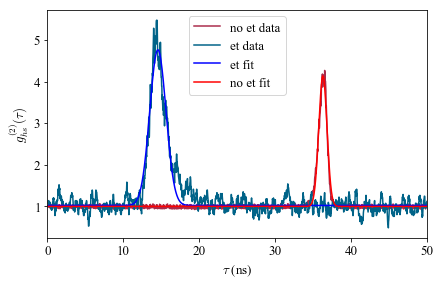

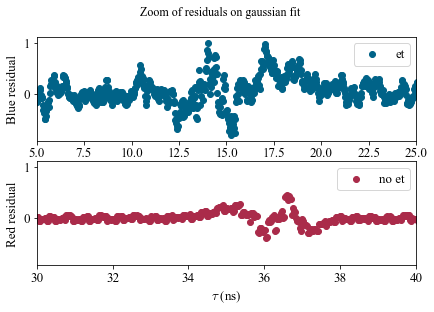

Blue FWHM =  2.52 ns
Red FWHM =  1.27 ns


In [32]:
## Fit gaussians to both peaks to get an estimate of width 
## including smoothing, which broadens peak

# fit to predefined gaussian
popt_blue, pcov_blue = scipy.optimize.curve_fit(gaussian, x_blue,y_blue, p0 = (blue_max, blue_max_time, 2,1))
popt_red, pcov_red = scipy.optimize.curve_fit(gaussian, x_red,y_red, p0 = (red_max, red_max_time, 2,1))

print('blue opt values = ', popt_blue)
print('red opt values = ', popt_red)

#np.savetxt(directoryname+"//"+'gaussian_fit_params.txt', np.array([popt_blue, popt_red]))

## plot data and fits
fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.set_xlabel("$\\tau$ (ns)")
ax1.set_ylabel("$g^{(2)}_{hs}(\\tau)$")

ax1.plot(x_red, y_red, color = cs[0], label = 'no et data')
ax1.plot(x_blue, y_blue, color = cs[1], label = 'et data')

ax1.plot(x_blue, gaussian(x_blue, popt_blue[0],popt_blue[1],popt_blue[2],popt_blue[3]), color = 'blue', label = 'et fit')
ax1.plot(x_red, gaussian(x_red, popt_red[0],popt_red[1],popt_red[2],popt_red[3]), color = 'red', label = 'no et fit')
ax1.set_xlim(0,50)

ax1.legend()
#plt.savefig(directoryname+"//"+'ghs_gaussfit-50.pdf')
plt.show()

## plot residuals zoomed 
fig = plt.figure()
fig.suptitle('Zoom of residuals on gaussian fit')
ax1 = fig.add_subplot(211)
ax1.scatter(x_blue, y_blue-gaussian(x_blue, popt_blue[0],popt_blue[1],popt_blue[2],popt_blue[3]), color = cs[1], label = 'et')
ax1.set_xlim(5,25)
ax1.set_ylabel("Blue residual")
ax1.legend()

ax2 = fig.add_subplot(212, sharey = ax1)

ax2.scatter(x_red, y_red-gaussian(x_red, popt_red[0],popt_red[1],popt_red[2],popt_red[3]), color = cs[0], label = 'no et')
ax2.set_xlim(30,40)
ax2.set_xlabel("$\\tau$ (ns)")
ax2.set_ylabel("Red residual")
ax2.legend()
#plt.savefig(directoryname+"//"+'ghs_gaussfit_res.pdf')
plt.show()


## Calculate Full width at half maximum from Gaussian
FWHM_blue = 2*np.sqrt(2 *np.log(2))*popt_blue[2]
FWHM_red = 2*np.sqrt(2 *np.log(2))*popt_red[2]

print('Blue FWHM = ', '{0:.2f}'.format(FWHM_blue), 'ns')
print('Red FWHM = ', '{0:.2f}'.format(FWHM_red), 'ns')

#np.savetxt(directoryname+"//"+'gaussian_FWHM.txt', np.array([FWHM_blue, FWHM_red]))

### Modelling shape of blue

It is clear even by eye that the through etalon peak is asymmetric and not well fitted by the gaussian. There looks to be some decay over time as each round trip the light has a chance of leaving the cavity (round trip loss).
We look at the geometrical decay of the light in the cavity. Assume the unaltered time profile is gaussian (the without-etalon peak) and this gaussian decays as photons leave the cavity. The final profile is therefore a convolution of the original gaussian and the decay.

In [15]:
## Define geometrical decay

def geo(n, x, a):
    '''geometrical decay. a is starting amplitude, x is the common ratio,  n is the term of the series to be calcuated'''
    return a * x**n

In [17]:
### it the convolution - floating parameters are RTL, then y scaling and x shift

def fittingconvolution(ns, RTL, a, b ):
    '''ns are a range of integers for each round trip, RTL is round trip loss, the thing we are really fitting, a is y-scaling factor, and b is x-shift input via centre of gaussian'''
    ts = np.arange(len(ns))
    decay = geo(ts, 1-RTL, 1) ## fraction of light remaining in cavity is 1 - RTL
    ## converting x-axis of gaussian into integer index. n = one round trip time.  cavity is 2.5mm long, 3e8 is speed of light, 1e9 converts [ns] to [s]
    ## using gaussian parameters calculated above
    no_et_shape = gaussian(ts*5e-3/3e8*1e9, popt_red[0],b,popt_red[2],popt_red[3])-1
    total_shape = np.convolve(no_et_shape, decay, mode = 'full')[:1000]
    return total_shape * a +1

In [18]:
## fit to the convolution function
popt_decay, pcov_decay = scipy.optimize.curve_fit(fittingconvolution, x_blue[:1000],y_blue[:1000], p0 = (0.02, 1/34,7))

fitted RTL =  0.02436506488943562
fit params =  [0.02436506 0.03937322 8.42264779]


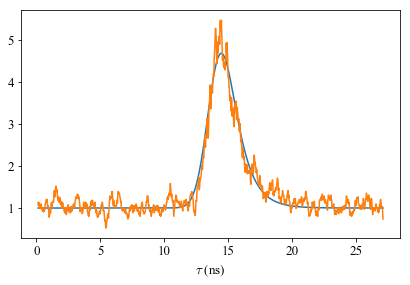

In [23]:
## Quick plot to check fit looks sensible
plt.plot(x_blue[:1000], fittingconvolution(x_blue, popt_decay[0], popt_decay[1], popt_decay[2]))[:1000]
plt.plot(x_blue[:1000], y_blue[:1000])
plt.xlabel('$\\tau$ (ns)')

print('fitted RTL = ', popt_decay[0])
print('fit params = ',popt_decay)

#np.savetxt(directoryname+"//"+'fittedRTL.txt', np.array([popt_decay[0]]))

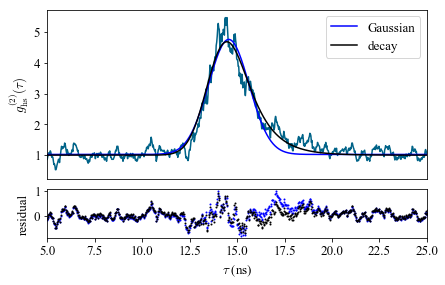

In [28]:
## Make proper figure

fig = plt.figure()
gs = gridspec.GridSpec(4, 1)
ax1 = fig.add_subplot(gs[0:3,0])
ax2 = fig.add_subplot(gs[3,0], sharex = ax1)


#ax1.set_xlabel("$\\tau$ (ns)")
ax1.set_ylabel("$g^{(2)}_\mathrm{hs}(\\tau)$")

#ax1.plot(x_red, y_red, color = cs[0])
ax1.plot(x_blue, y_blue, color = cs[1])

ax1.plot(x_blue, gaussian(x_blue, popt_blue[0],popt_blue[1],popt_blue[2],popt_blue[3]), color = 'blue', label = 'Gaussian')
#ax1.plot(x_red, gaussian(x_red, popt_red[0],popt_red[1],popt_red[2],popt_red[3]), color = 'red')
ax1.plot(x_blue[:1000], fittingconvolution(x_blue, popt_decay[0], popt_decay[1], popt_decay[2])[:1000], color = 'k', label = 'decay')
#ax1.set_xlim(5,25)
ax1.legend()
ax1.xaxis.set_visible(False)


ax2.scatter(x_blue, y_blue-gaussian(x_blue, popt_blue[0],popt_blue[1],popt_blue[2],popt_blue[3]), s = 1, label = 'Gaussian', color = 'b')
ax2.scatter(x_blue[:1000], y_blue[:1000]-fittingconvolution(x_blue, popt_decay[0], popt_decay[1], popt_decay[2])[:1000], color = 'k', s =1, label = 'Decay')

ax2.set_xlim(5,25)
ax2.set_xlabel("$\\tau$ (ns)")
ax2.set_ylabel("residual")

#ax2.legend(loc =1)
#plt.savefig(directoryname+"//"+'ghs_gauss_and_decay_oneplot.pdf',bbox_inches = 'tight')
plt.show()



By eye it is clearer on the main plot than the residuals plot that the decay gives a better fit. Calculate RMS error to quantify this.

In [29]:
def RMSerror(data, fit):
    '''function takes set of data points and corresponding fit points and returns one float - root mean squared error'''
    return (np.sum((data-fit)**2)/len(data))**0.5

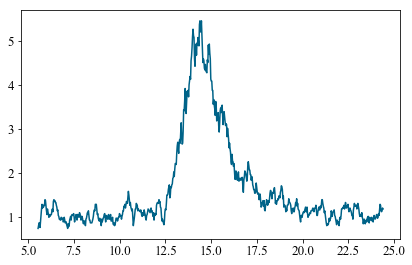

In [35]:
## quickly choose smaller section to calculate error on, othervise RMS difference from fits is tiny compared to total RMS error

start = 200; end = 900
plt.plot(x_blue[200:900], y_blue[200:900], color = cs[1])

In [36]:
# Calculate RMS error only using section of data near feature

rms_gauss = RMSerror(y_blue[200:900], gaussian(x_blue, popt_blue[0],popt_blue[1],popt_blue[2],popt_blue[3])[200:900])
rms_decay = RMSerror(y_blue[200:900], fittingconvolution(x_blue, popt_decay[0], popt_decay[1], popt_decay[2])[200:900])
print('Gaussian RMS error = ', '{0:.2f}'.format(rms_gauss))
print('Decay RMS error = ', '{0:.2f}'.format(rms_decay))

Gaussian RMS error =  0.28
Decay RMS error =  0.23
